#### Disclaimer
###### This method has been pulled/inspired from **RAIDAR**:
###### **Paper Reference:** [https://arxiv.org/abs/2401.12970](https://arxiv.org/abs/2401.12970)
###### Please refer to the original paper for complete methodological details and proper attribution.

In [1]:
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json


In [2]:
with open('../../data/aigcodeset_perturbations_levenshtein.json', 'r') as f:
    data = json.load(f)

dataset = Dataset.from_list(list(data.values())).to_pandas()


In [ ]:
dataset

,original_code,modified_code,target,levenshtein_distance,original_length,modified_length,dataset_index
0,import sys\n\ndef main():\n\n # sys.stdin =...,"def main():\n n, k = map(int, input().split...",1,75,229,169,0
1,# coding: utf-8\n# Your code here!\nimport num...,n = int(input())\nm = input().strip().split()\...,0,151,294,216,1
2,\nimport operator\nclass SegmentTree:\n def...,"class SegmentTree:\n def __init__(self, n, ...",0,1927,2881,1517,2
3,N = int(input())\ntotal_value = 0\n\nfor _ in ...,N = int(input())\n\ntotal_value = 0\n\nfor _ i...,1,6,260,260,3
4,def can_permute(a):\n n = len(a)\n for i...,def can_permute(nums):\n for i in range(len...,1,46,336,347,4
...,...,...,...,...,...,...,...
7575,"n, m, x = map(int, input().split())\nC = {}\na...","n, m, x = map(int, input().split())\nc = {}\na...",0,90,538,469,7575
7576,def f(n):\n if n%2==0:\n return int(...,def f(n):\n return int((n % 2 == 0) * n // ...,0,73,213,223,7576
7577,"A, B, M = map(int,input().split())\na = list(m...","A, B, M = map(int,input().split())\na = list(m...",0,204,464,280,7577
7578,"import numpy as np\na,b = map(int,input().spli...","import numpy as np\n\na, b = map(int, input()....",0,138,339,443,7578


In [ ]:
human = dataset[dataset['target'] == 0]
ai = dataset[dataset['target'] == 1]

In [ ]:
print(f"Human subset size: {len(human)}")
print(f"AI subset size: {len(ai)}")
print(f"Human levenshtein_distance NaN count: {human['levenshtein_distance'].isna().sum()}")
print(f"AI levenshtein_distance NaN count: {ai['levenshtein_distance'].isna().sum()}")
print(f"Human levenshtein_distance dtype: {human['levenshtein_distance'].dtype}")
print(f"AI levenshtein_distance dtype: {ai['levenshtein_distance'].dtype}")

Human subset size: 4753
AI subset size: 2827
Human levenshtein_distance NaN count: 0
AI levenshtein_distance NaN count: 0
Human levenshtein_distance dtype: int64
AI levenshtein_distance dtype: int64


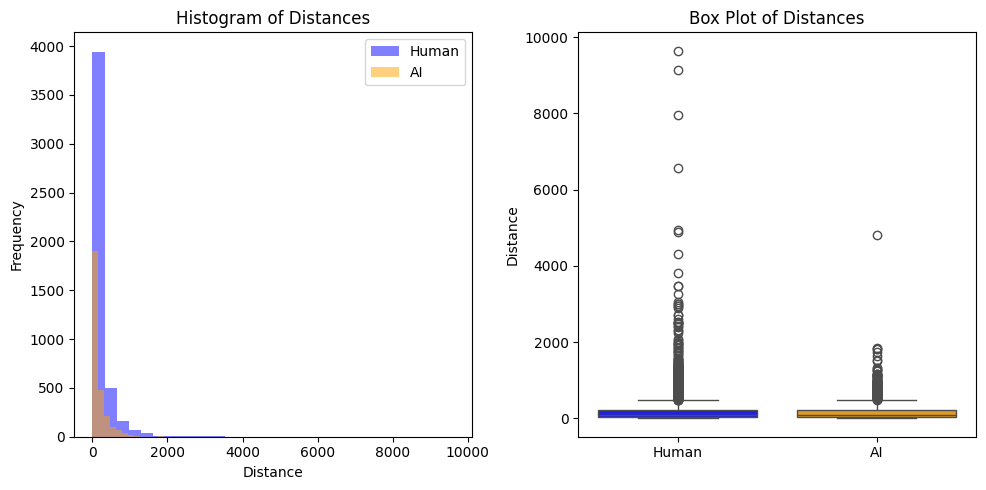

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(human['levenshtein_distance'], bins=30, alpha=0.5, label='Human', color='blue')
plt.hist(ai['levenshtein_distance'], bins=30, alpha=0.5, label='AI', color='orange')
plt.title('Histogram of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 2)
plot_data = pd.DataFrame({
    'Human': human['levenshtein_distance'],
    'AI': ai['levenshtein_distance']
})

sns.boxplot(data=plot_data, palette=['blue', 'orange'])
plt.title('Box Plot of Distances')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    dataset[['levenshtein_distance']],
    dataset['target'],
    test_size=0.2,
    stratify=dataset['target'],
    random_state=12345
    )


In [ ]:
print(len(x_train))
print(len(x_test))

6064
1516


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1, class_weight='balanced')

model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [ ]:
preds = model.predict(x_test)

In [ ]:
preds

array([0, 1, 1, ..., 1, 1, 1], shape=(1516,))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score

acc = accuracy_score(preds, y_test)
recall = recall_score(preds, y_test)
precision = precision_score(preds, y_test)
f1 = f1_score(preds, y_test)
report = classification_report(preds, y_test)

In [14]:
print(f"Accuracy: {acc:.4f}")
print(f"Classification report:\n{report}")

Accuracy: 0.4446
Classification report:
              precision    recall  f1-score   support

           0       0.30      0.62      0.40       455
           1       0.69      0.37      0.48      1061

    accuracy                           0.44      1516
   macro avg       0.50      0.49      0.44      1516
weighted avg       0.57      0.44      0.46      1516



In [15]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, preds))


[[282 669]
 [173 392]]


In [16]:
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("file:///home/bosa/diplomska/mlruns")

mlflow.set_experiment("AIGCodeSet")
mlflow_run_name = "levenshtein_distance_logisticregression"
experiment_id = mlflow.get_experiment_by_name("AIGCodeSet").experiment_id
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.mlflow.runName = '{mlflow_run_name}'",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
)
run_id = runs["run_id"].iloc[0] if not runs.empty else None
with mlflow.start_run(run_id=run_id, run_name=mlflow_run_name) as run:
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)

    # Log input example for model inference
    input_example = x_test[:1]  # Use first test sample as example
    
    mlflow.sklearn.log_model(model, "model", input_example=input_example)

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=12345)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=12345)

In [18]:
preds = model.predict(x_test)

acc = accuracy_score(preds, y_test)
recall = recall_score(preds, y_test)
precision = precision_score(preds, y_test)
f1 = f1_score(preds, y_test)
report = classification_report(preds, y_test)

In [19]:
from sklearn.metrics import classification_report

acc = accuracy_score(preds, y_test)
report = classification_report(preds, y_test)

In [20]:
print(f"Accuracy: {acc:.4f}")
print(f"Classification report:\n{report}")

Accuracy: 0.5277
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       889
           1       0.42      0.38      0.40       627

    accuracy                           0.53      1516
   macro avg       0.51      0.51      0.51      1516
weighted avg       0.52      0.53      0.52      1516



In [21]:
mlflow.set_experiment("AIGCodeSet")
mlflow_run_name = "levenshtein_distance_randomforest"
experiment_id = mlflow.get_experiment_by_name("AIGCodeSet").experiment_id
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.mlflow.runName = '{mlflow_run_name}'",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
)
run_id = runs["run_id"].iloc[0] if not runs.empty else None
with mlflow.start_run(run_id=run_id, run_name=mlflow_run_name) as run:
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)

    
    input_example = x_test[:1]  
    
    mlflow.sklearn.log_model(model, "model", input_example=input_example)

In [22]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.dataset import AIGCodeSet_WithCSTFeatures
from datasets import concatenate_datasets

In [30]:
train_cst, val_cst, test_cst = AIGCodeSet_WithCSTFeatures(cache_dir='../../data', features_as_tensor=False).get_dataset(split=True)
# Concatenate and explore dataset
dataset_cst = concatenate_datasets([train_cst, val_cst, test_cst])

In [31]:
dataset_cst = dataset_cst.to_pandas()

In [38]:
dataset_cst

,code,function_defs,if_statements,loops,imports,comments,class_defs,max_nesting_depth,binary_ops,errors,target
0,import sys\n\ndef main():\n\n # sys.stdin =...,1,1,1,1,1,0,2,0,0,1
1,# coding: utf-8\n# Your code here!\nimport num...,0,0,1,1,1,0,1,1,0,0
2,\nimport operator\nclass SegmentTree:\n def...,1,1,2,2,1,1,4,1,0,0
3,N = int(input())\ntotal_value = 0\n\nfor _ in ...,0,1,1,0,0,0,2,1,0,1
4,def can_permute(a):\n n = len(a)\n for i...,1,1,1,0,0,0,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7578,"n, m, x = map(int, input().split())\nC = {}\na...",0,1,1,0,0,0,3,1,0,0
7579,def f(n):\n if n%2==0:\n return int(...,1,1,1,0,0,0,2,1,0,0
7580,"A, B, M = map(int,input().split())\na = list(m...",0,1,1,0,1,0,3,1,0,0
7581,"import numpy as np\na,b = map(int,input().spli...",0,1,0,1,0,0,1,1,0,0


In [37]:
dataset

,original_code,modified_code,target,levenshtein_distance,original_length,modified_length,dataset_index,features
0,import sys\n\ndef main():\n\n # sys.stdin =...,"def main():\n n, k = map(int, input().split...",1,75,229,169,0,"[1, 1, 1, 1, 1, 0, 2, 0, 0]"
1,# coding: utf-8\n# Your code here!\nimport num...,n = int(input())\nm = input().strip().split()\...,0,151,294,216,1,"[0, 0, 1, 1, 1, 0, 1, 1, 0]"
2,\nimport operator\nclass SegmentTree:\n def...,"class SegmentTree:\n def __init__(self, n, ...",0,1927,2881,1517,2,"[1, 1, 2, 2, 1, 1, 4, 1, 0]"
3,N = int(input())\ntotal_value = 0\n\nfor _ in ...,N = int(input())\n\ntotal_value = 0\n\nfor _ i...,1,6,260,260,3,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
4,def can_permute(a):\n n = len(a)\n for i...,def can_permute(nums):\n for i in range(len...,1,46,336,347,4,"[1, 1, 1, 0, 0, 0, 3, 1, 0]"
...,...,...,...,...,...,...,...,...
7575,"n, m, x = map(int, input().split())\nC = {}\na...","n, m, x = map(int, input().split())\nc = {}\na...",0,90,538,469,7575,"[0, 1, 0, 0, 0, 0, 1, 0, 0]"
7576,def f(n):\n if n%2==0:\n return int(...,def f(n):\n return int((n % 2 == 0) * n // ...,0,73,213,223,7576,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
7577,"A, B, M = map(int,input().split())\na = list(m...","A, B, M = map(int,input().split())\na = list(m...",0,204,464,280,7577,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
7578,"import numpy as np\na,b = map(int,input().spli...","import numpy as np\n\na, b = map(int, input()....",0,138,339,443,7578,"[0, 1, 1, 0, 0, 0, 3, 1, 0]"


In [36]:
select_columns = dataset_cst.columns.drop(['code', 'target'])
dataset['features'] = dataset_cst[]

Index(['function_defs', 'if_statements', 'loops', 'imports', 'comments',
       'class_defs', 'max_nesting_depth', 'binary_ops', 'errors'],
      dtype='object')

In [29]:
dataset

,original_code,modified_code,target,levenshtein_distance,original_length,modified_length,dataset_index,features
0,import sys\n\ndef main():\n\n # sys.stdin =...,"def main():\n n, k = map(int, input().split...",1,75,229,169,0,"[1, 1, 1, 1, 1, 0, 2, 0, 0]"
1,# coding: utf-8\n# Your code here!\nimport num...,n = int(input())\nm = input().strip().split()\...,0,151,294,216,1,"[0, 0, 1, 1, 1, 0, 1, 1, 0]"
2,\nimport operator\nclass SegmentTree:\n def...,"class SegmentTree:\n def __init__(self, n, ...",0,1927,2881,1517,2,"[1, 1, 2, 2, 1, 1, 4, 1, 0]"
3,N = int(input())\ntotal_value = 0\n\nfor _ in ...,N = int(input())\n\ntotal_value = 0\n\nfor _ i...,1,6,260,260,3,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
4,def can_permute(a):\n n = len(a)\n for i...,def can_permute(nums):\n for i in range(len...,1,46,336,347,4,"[1, 1, 1, 0, 0, 0, 3, 1, 0]"
...,...,...,...,...,...,...,...,...
7575,"n, m, x = map(int, input().split())\nC = {}\na...","n, m, x = map(int, input().split())\nc = {}\na...",0,90,538,469,7575,"[0, 1, 0, 0, 0, 0, 1, 0, 0]"
7576,def f(n):\n if n%2==0:\n return int(...,def f(n):\n return int((n % 2 == 0) * n // ...,0,73,213,223,7576,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
7577,"A, B, M = map(int,input().split())\na = list(m...","A, B, M = map(int,input().split())\na = list(m...",0,204,464,280,7577,"[0, 1, 1, 0, 0, 0, 2, 1, 0]"
7578,"import numpy as np\na,b = map(int,input().spli...","import numpy as np\n\na, b = map(int, input()....",0,138,339,443,7578,"[0, 1, 1, 0, 0, 0, 3, 1, 0]"


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset[['levenshtein_distance']],
    dataset['target'],
    test_size=0.2,
    stratify=dataset['target'],
    random_state=12345
    )

In [ ]:
merged_dataset = dataset.copy()

cst_feature_columns = [col for col in dataset_cst.columns if col not in ['code', 'target']]

for col in cst_feature_columns:
    merged_dataset[col] = None


cst_code_to_features = {}
for idx, row in dataset_cst.iterrows():
    code = row['code']
    features = {col: row[col] for col in cst_feature_columns}
    cst_code_to_features[code] = features

for idx, row in merged_dataset.iterrows():
    original_code = row['original_code']
    if original_code in cst_code_to_features:
        for col in cst_feature_columns:
            merged_dataset.at[idx, col] = cst_code_to_features[original_code][col]

column_order = ['original_code'] + ['levenshtein_distance'] + cst_feature_columns + ['target']

merged_dataset = merged_dataset[column_order].rename(columns={'original_code': 'code'})

print(f"\nFinal merged dataset shape: {merged_dataset.shape}")
print(f"Final merged dataset columns: {merged_dataset.columns.tolist()}")

Starting merge process...
CST feature columns to merge: ['function_defs', 'if_statements', 'loops', 'imports', 'comments', 'class_defs', 'max_nesting_depth', 'binary_ops', 'errors']
Created mapping for 7453 CST records
Successfully matched 7580 out of 7580 records

Final merged dataset shape: (7580, 12)
Final merged dataset columns: ['code', 'levenshtein_distance', 'function_defs', 'if_statements', 'loops', 'imports', 'comments', 'class_defs', 'max_nesting_depth', 'binary_ops', 'errors', 'target']


In [43]:
# Create train-test split with combined features (Levenshtein + CST)
feature_columns = ['levenshtein_distance'] + cst_feature_columns
print(f"Using features: {feature_columns}")

X_combined = dataset[feature_columns]
y_combined = dataset['target']

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined,
    y_combined,
    test_size=0.2,
    stratify=y_combined,
    random_state=12345
)

print(f"Training set shape: {X_train_combined.shape}")
print(f"Test set shape: {X_test_combined.shape}")
print(f"Features: {X_train_combined.columns.tolist()}")

Using features: ['levenshtein_distance', 'function_defs', 'if_statements', 'loops', 'imports', 'comments', 'class_defs', 'max_nesting_depth', 'binary_ops', 'errors']
Training set shape: (6064, 10)
Test set shape: (1516, 10)
Features: ['levenshtein_distance', 'function_defs', 'if_statements', 'loops', 'imports', 'comments', 'class_defs', 'max_nesting_depth', 'binary_ops', 'errors']


In [ ]:
# Scale all combined features (Levenshtein + CST)
scaler_combined = StandardScaler()
X_train_combined_scaled = scaler_combined.fit_transform(X_train_combined)
X_test_combined_scaled = scaler_combined.transform(X_test_combined)


lr_combined = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=12345)
lr_combined.fit(X_train_combined_scaled, y_train_combined)

lr_preds_combined = lr_combined.predict(X_test_combined_scaled)

lr_acc_combined = accuracy_score(y_test_combined, lr_preds_combined)
lr_recall_combined = recall_score(y_test_combined, lr_preds_combined)
lr_precision_combined = precision_score(y_test_combined, lr_preds_combined)
lr_f1_combined = f1_score(y_test_combined, lr_preds_combined)
lr_report_combined = classification_report(y_test_combined, lr_preds_combined)

print(f"Logistic Regression - Combined Scaled Features:")
print(f"Accuracy: {lr_acc_combined:.4f}")
print(f"Precision: {lr_precision_combined:.4f}")
print(f"Recall: {lr_recall_combined:.4f}")
print(f"F1-Score: {lr_f1_combined:.4f}")
print(f"Classification report:\n{lr_report_combined}")

All features scaled successfully

Training Logistic Regression with combined scaled features...
Logistic Regression - Combined Scaled Features:
Accuracy: 0.5574
Precision: 0.4230
Recall: 0.5150
F1-Score: 0.4645
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       951
           1       0.42      0.52      0.46       565

    accuracy                           0.56      1516
   macro avg       0.55      0.55      0.54      1516
weighted avg       0.58      0.56      0.56      1516

Logistic Regression - Combined Scaled Features:
Accuracy: 0.5574
Precision: 0.4230
Recall: 0.5150
F1-Score: 0.4645
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       951
           1       0.42      0.52      0.46       565

    accuracy                           0.56      1516
   macro avg       0.55      0.55      0.54      1516
weighted avg       0.58      

In [ ]:
rf_combined = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=100)
rf_combined.fit(X_train_combined_scaled, y_train_combined)  # Using scaled features for consistency

rf_preds_combined = rf_combined.predict(X_test_combined_scaled)

rf_acc_combined = accuracy_score(y_test_combined, rf_preds_combined)
rf_recall_combined = recall_score(y_test_combined, rf_preds_combined)
rf_precision_combined = precision_score(y_test_combined, rf_preds_combined)
rf_f1_combined = f1_score(y_test_combined, rf_preds_combined)
rf_report_combined = classification_report(y_test_combined, rf_preds_combined)

print(f"Accuracy: {rf_acc_combined:.4f}")
print(f"Precision: {rf_precision_combined:.4f}")
print(f"Recall: {rf_recall_combined:.4f}")
print(f"F1-Score: {rf_f1_combined:.4f}")
print(f"Classification report:\n{rf_report_combined}")

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_combined.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance (Random Forest - Scaled Features):")
print(feature_importance)


Training Random Forest with combined scaled features...
Random Forest - Combined Scaled Features:
Accuracy: 0.5521
Precision: 0.3944
Recall: 0.3770
F1-Score: 0.3855
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       951
           1       0.39      0.38      0.39       565

    accuracy                           0.55      1516
   macro avg       0.52      0.52      0.52      1516
weighted avg       0.55      0.55      0.55      1516


Feature Importance (Random Forest - Scaled Features):
                feature  importance
0  levenshtein_distance    0.770290
7     max_nesting_depth    0.075540
4               imports    0.034322
3                 loops    0.032307
5              comments    0.021968
1         function_defs    0.017980
8            binary_ops    0.015392
2         if_statements    0.013773
9                errors    0.013184
6            class_defs    0.005243
Random Forest - Combined Scaled F

In [ ]:
mlflow.set_experiment("AIGCodeSet")
mlflow_run_name = "levenshtein_cst_combined_scaled_logisticregression"
experiment_id = mlflow.get_experiment_by_name("AIGCodeSet").experiment_id
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.mlflow.runName = '{mlflow_run_name}'",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
)
run_id = runs["run_id"].iloc[0] if not runs.empty else None

with mlflow.start_run(run_id=run_id, run_name=mlflow_run_name) as run:
    mlflow.log_metric("test_accuracy", lr_acc_combined)
    mlflow.log_metric("test_f1", lr_f1_combined)
    mlflow.log_metric("recall", lr_recall_combined)
    mlflow.log_metric("precision", lr_precision_combined)
    mlflow.log_param("features_used", "levenshtein_distance + CST_features (all scaled)")
    mlflow.log_param("num_features", len(feature_columns))
    mlflow.log_param("feature_scaling", "StandardScaler")
    
    input_example = X_test_combined_scaled[:1]
    mlflow.sklearn.log_model(lr_combined, "model", input_example=input_example)


mlflow_run_name = "levenshtein_cst_combined_scaled_randomforest"
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"tags.mlflow.runName = '{mlflow_run_name}'",
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
)
run_id = runs["run_id"].iloc[0] if not runs.empty else None

with mlflow.start_run(run_id=run_id, run_name=mlflow_run_name) as run:
    mlflow.log_metric("test_accuracy", rf_acc_combined)
    mlflow.log_metric("test_f1", rf_f1_combined)
    mlflow.log_metric("recall", rf_recall_combined)
    mlflow.log_metric("precision", rf_precision_combined)
    mlflow.log_param("features_used", "levenshtein_distance + CST_features (all scaled)")
    mlflow.log_param("num_features", len(feature_columns))
    mlflow.log_param("feature_scaling", "StandardScaler")
    
    input_example = X_test_combined_scaled[:1]
    mlflow.sklearn.log_model(rf_combined, "model", input_example=input_example)



Logistic Regression with combined scaled features logged to MLflow
Random Forest with combined scaled features logged to MLflow
Random Forest with combined scaled features logged to MLflow
